In [ ]:
!uv add -qU langgraph langchain langchain-openai

In [1]:
!uv add -q python-dotenv

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

## Orchestrator-Worker

### Model 정의


In [3]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gpt-5-nano",)

### State 정의

In [4]:
from typing import List
from pydantic import Field, BaseModel

# 1. 데이터 모델 정의 (Plan & Section)
# 팀장(Orchestrator)이 짤 계획표의 양식
class Section(BaseModel):
    name: str = Field(description='목차의 제목')
    description: str = Field(description='이 섹션에서 다뤄야 할 핵심 내용')

In [5]:
import operator
from typing import Annotated, TypedDict

# 2. State 정의 (Reducer 필수!)
class ReportState(TypedDict):
    topic: str
    sections: List[Section]
    completed_secitons: Annotated[List[str], operator.add]
    final_report: str

In [6]:
# Wroker에게 전달할 별도의 State (작업 지시서)
class WorkerState(TypedDict):
    section: Section

In [7]:
class Plan(BaseModel):
    sections: List[Section] = Field(description="보고서 작성을 위한 목차 리스트")

In [8]:
planner_llm = model.with_structured_output(Plan)

### Node 정의

In [9]:
# [Orchestrator] 팀장 노드: 계획 수립
def orchestrator_node(state: ReportState):
    topic = state["topic"]
    print(f"\n--- [Orchestrator] '{topic}' 보고서 계획 수립 중 ---")

    # 보고서 목차를 생성 (최대 3개로 제한하여 속도 조절)
    plan = planner_llm.invoke(f"'{topic}'에 대한 보고서 목차를 짜줘. 5개 섹션 이내로 구성해.")

    print(f"생성된 계획: {[s.name for s in plan.sections]}")
    return {"sections": plan.sections}

In [10]:
# [Worker] 팀원 노드: 섹션 집필
# 이 노드는 여러 개가 복제되어 동시에 실행
def worker_node(state: WorkerState):
    section = state["section"]
    print(f" --- [Worker] 집필 중: {section.name} ---")

    prompt = f"""
    다음 섹션에 대한 내용을 짧게 작성해줘.
    제목: {section.name}
    내용 가이드: {section.description}
    """
    res = model.invoke(prompt)
    content = f'## {section.name} \n {res.content}'
    return {'completed_secitons': [content]}

In [11]:
# [Synthesizer] 편집자 노드 : 취합
def synthesizer_node(state: ReportState):
    print("\n--- [Synthesizer] 모든 원고 취합 및 최종 편집 ---")

    # 리스트에 모인 조각글들을 하나로 합침
    completed = state["completed_secitons"]
    final_report = "\n".join(completed)

    return {"final_report": final_report}

### Grpah


In [13]:
from langgraph.graph import StateGraph, START, END

In [12]:
from langgraph.types import Send

# 5. 동적 라우팅 로직 (Map: 1 -> N)
# 일반적인 edge가 아니라, 리스트 개수만큼 노드를 생성해서 뿌려주는 역할
def assign_workers(state: ReportState):
    sections = state['sections']
    return [Send('worker_node', {'section': section}) for section in sections]

In [14]:
# 6. 그래프 조립
workflow = StateGraph(ReportState)

workflow.add_node('orchestrator_node', orchestrator_node)
workflow.add_node('worker_node', worker_node)
workflow.add_node('synthesizer_node', synthesizer_node)

# 6-1. 시작 -> 팀장
workflow.add_edge(START, 'orchestrator_node')

# 6-2. 팀장 -> (Map) -> 팀원들 (Conditional Edge)
workflow.add_conditional_edges(
    'orchestrator_node',
    assign_workers,
    ['worker_node']
)

# 6-3. 팀원들 -> (Reduce) -> 편집자
workflow.add_edge('worker_node', 'synthesizer_node')

# 6-4. 편집자 -> 종료
workflow.add_edge('synthesizer_node', END)

In [15]:
app = workflow.compile()

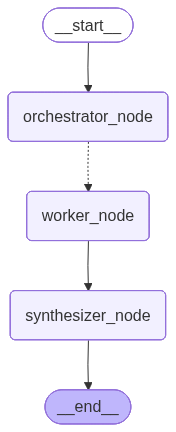

In [16]:
app

In [17]:
inputs = {"topic": "생성형 AI의 미래"}
result = app.invoke(inputs)


--- [Orchestrator] '생성형 AI의 미래' 보고서 계획 수립 중 ---


/Users/sup_kimba/langgraph-basic/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=Plan(sections=[Section(na...략을 제안한다.')]), input_type=Plan])
  return self.__pydantic_serializer__.to_python(


생성된 계획: ['1. 서론: 생성형 AI의 개념과 현황', '2. 기술 진보의 방향과 미래 트렌드', '3. 산업적 응용과 경제 영향', '4. 사회적 도전과 거버넌스', '5. 미래 시나리오와 전략적 제언']
 --- [Worker] 집필 중: 1. 서론: 생성형 AI의 개념과 현황 ---
 --- [Worker] 집필 중: 2. 기술 진보의 방향과 미래 트렌드 ---
 --- [Worker] 집필 중: 3. 산업적 응용과 경제 영향 ---
 --- [Worker] 집필 중: 4. 사회적 도전과 거버넌스 ---
 --- [Worker] 집필 중: 5. 미래 시나리오와 전략적 제언 ---

--- [Synthesizer] 모든 원고 취합 및 최종 편집 ---


In [19]:
result

{'topic': '생성형 AI의 미래',
 'sections': [Section(name='1. 서론: 생성형 AI의 개념과 현황', description='생성형 AI의 정의, 기술적 배경, 최근 발전 현황과 보고서의 목적·범위를 제시한다.'),
  Section(name='2. 기술 진보의 방향과 미래 트렌드', description='모델 구조·데이터·안전성 강화, 학습 방식의 변화, 인간-AI 협력의 진화 등 향후 기술 방향을 정리한다.'),
  Section(name='3. 산업적 응용과 경제 영향', description='주요 산업의 적용 사례, 생산성 증대와 새로운 비즈니스 모델, 고용·노동시장 영향 등을 분석한다.'),
  Section(name='4. 사회적 도전과 거버넌스', description='윤리·편향성·개인정보·저작권 이슈, 안전성·책임 소재, 규제 프레임워크와 정책 제언을 다룬다.'),
  Section(name='5. 미래 시나리오와 전략적 제언', description='긍정적/부정적 시나리오를 제시하고, 리스크 관리와 기업·정부를 위한 로드맵 및 실행 전략을 제안한다.')],
 'completed_secitons': ['## 1. 서론: 생성형 AI의 개념과 현황 \n 1. 서론: 생성형 AI의 개념과 현황\n- 정의: 생성형 AI는 인간의 의도에 따라 텍스트, 이미지, 음성 등 새로운 콘텐츠를 자동으로 생성하는 인공지능 기술이다.\n- 기술적 배경: 딥러닝 기반의 대형 언어 모델(LM), 트랜스포머 아키텍처, 확률적 생성 모델, 멀티모달 융합, 프롬프트 엔지니어링 등으로 뒷받침된다.\n- 최근 발전 현황: 대형 모델의 상용화 확대, 멀티모달 생성 확산, 코드/콘텐츠 자동화, API 중심 플랫폼 증가와 안전성 연구 강화가 진행 중이다.\n- 보고서의 목적·범위: 현황 파악과 활용·규제 이슈를 정리하고 산업별 영향과 정책적 시사점을 제시한다. 범위는 최근 3–5년의 기술 발전과 실제 적용 사례를 포함하며, 윤리·안전·개인정보

In [18]:
result["final_report"]

'## 1. 서론: 생성형 AI의 개념과 현황 \n 1. 서론: 생성형 AI의 개념과 현황\n- 정의: 생성형 AI는 인간의 의도에 따라 텍스트, 이미지, 음성 등 새로운 콘텐츠를 자동으로 생성하는 인공지능 기술이다.\n- 기술적 배경: 딥러닝 기반의 대형 언어 모델(LM), 트랜스포머 아키텍처, 확률적 생성 모델, 멀티모달 융합, 프롬프트 엔지니어링 등으로 뒷받침된다.\n- 최근 발전 현황: 대형 모델의 상용화 확대, 멀티모달 생성 확산, 코드/콘텐츠 자동화, API 중심 플랫폼 증가와 안전성 연구 강화가 진행 중이다.\n- 보고서의 목적·범위: 현황 파악과 활용·규제 이슈를 정리하고 산업별 영향과 정책적 시사점을 제시한다. 범위는 최근 3–5년의 기술 발전과 실제 적용 사례를 포함하며, 윤리·안전·개인정보 보호 및 거버넌스도 다룬다.\n## 2. 기술 진보의 방향과 미래 트렌드 \n 2. 기술 진보의 방향과 미래 트렌드\n\n- 모델 구조: 멀티모달과 계층적/혼합 전문가 아키텍처의 확산, 파라미터 효율성 증가, 모듈식 재사용성과 동적 확장성 강화.\n\n- 데이터와 데이터 거버넌스: 고품질 데이터 확보와 투명한 거버넌스, 프라이버시 중심의 처리, 합성 데이터 활용 확대, 검색 기반 학습(RAG)과 데이터 선별의 중요성 증가.\n\n- 안전성 강화: 정합성·윤리성 확보를 위한 지속적 평가, 악용 방지 및 안전성 감독 프레임워크 구축, 규범 준수 및 위험 관리 체계 강화.\n\n- 학습 방식의 변화: 온라인/연속 학습, 자기주도 학습 및 자동화된 라벨링, 강화학습 기반 피드백(RLHF)의 확장, 프롬프트 튜닝과 파인튜닝의 하이브리드화.\n\n- 인간-AI 협력의 진화: 보조 도구에서 동반자로의 진화, 상황 인식과 해석성 강화, 책임 소재 명확화와 협력적 의사결정 지원.\n\n- 생태계 및 거버넌스: 국제 표준화와 개방형 생태계 촉진, 데이터 접근성과 투명성 강화, 정책/규제 대응 및 오픈소스 협력의 확대.\n## 3. 산업적 응용과 경제 영향 \n 3. 산업적

### Develop (화학접 결합)

In [20]:
# [Synthesizer] 편집자 노드: 단순 취합이 아니라 '화학적 결합'을 수행
def synthesizer_node(state: ReportState):
    topic = state['topic']
    completed_docs = state['completed_secitons']

    print(f"\n--- [Synthesizer] 원고 {len(completed_docs)}건 도착. 최종 편집 시작 ---")

    # 1. 일단 텍스트 덩어리로 병합
    raw_content = "\n\n".join(completed_docs)

    # 2. LLM에게 '전문 편집자' 역할 부여
    prompt = f"""
    당신은 전문 리포트 편집자입니다.
    다음은 '{topic}'에 대해 여러 작가가 나누어 쓴 원고들입니다.

    이 초안들을 바탕으로 **하나의 자연스럽고 전문적인 보고서**로 다시 작성해주세요.

    [지시사항]
    1. 각 섹션의 연결이 매끄러워야 합니다.
    2. 전체를 아우르는 '서론'과 '결론'을 추가해주세요.
    3. 마크다운(Markdown) 형식을 사용하여 가독성을 높여주세요.

    [원고 내용]
    {raw_content}
    """

    # 최종 생성을 위한 LLM 호출
    msg = model.invoke(prompt)

    return {'final_report' : msg.content}

In [21]:
# 6. 그래프 조립
workflow = StateGraph(ReportState)

workflow.add_node("orchestrator_node", orchestrator_node)
workflow.add_node("worker_node", worker_node)
workflow.add_node("synthesizer_node", synthesizer_node)

# 1. 시작 -> 팀장
workflow.add_edge(START, "orchestrator_node")

# 2. 팀장 -> (Map) -> 팀원들 (Conditional Edge)
workflow.add_conditional_edges(
    "orchestrator_node",
    assign_workers,
    ["worker_node"] # 이 부분은 생략 가능하지만 명시적으로 적어줌
)

# 3. 팀원들 -> (Reduce) -> 편집자
workflow.add_edge('worker_node', 'synthesizer_node')

# 4. 편집자 -> 종료
workflow.add_edge('synthesizer_node', END)

In [22]:
app = workflow.compile()

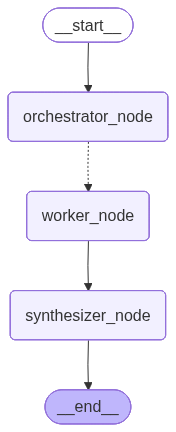

In [23]:
app

In [24]:
inputs = {'topic': '생성형 AI의 미래'}
result = app.invoke(inputs)


--- [Orchestrator] '생성형 AI의 미래' 보고서 계획 수립 중 ---


/Users/sup_kimba/langgraph-basic/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=Plan(sections=[Section(na...오를 제시한다.')]), input_type=Plan])
  return self.__pydantic_serializer__.to_python(


생성된 계획: ['서론: 생성형 AI의 정의와 연구 흐름', '현황과 핵심 기술', '산업별 영향 및 사례 연구', '정책, 윤리, 거버넌스', '미래 전망과 로드맵']
 --- [Worker] 집필 중: 서론: 생성형 AI의 정의와 연구 흐름 ---
 --- [Worker] 집필 중: 현황과 핵심 기술 ---
 --- [Worker] 집필 중: 산업별 영향 및 사례 연구 ---
 --- [Worker] 집필 중: 정책, 윤리, 거버넌스 ---
 --- [Worker] 집필 중: 미래 전망과 로드맵 ---

--- [Synthesizer] 원고 5건 도착. 최종 편집 시작 ---


In [25]:
result["final_report"]

'# 생성형 AI의 미래: 연구 흐름과 사회경제적 함의\n\n서론\n- 생성형 AI는 학습된 모델이 텍스트, 이미지, 음성 등 다양한 형태의 데이터를 바탕으로 새로운 콘텐츠를 자동으로 만들어내는 기술이다. 이 보고서는 대형 언어 모델(LLM)과 확산 모델 같은 확률적 생성 알고리즘, 프롬프트 기반 제어, 생성 과정의 해석 가능성과 안전성 등을 핵심으로 다룬다. 기술 발전의 맥락은 방대한 데이터와 고성능 컴퓨팅의 보급, 사전학습-미세조정 파이프라인의 발전, 평가 및 안전성 연구의 병행으로 요약된다.\n- 본 보고서는 생성형 AI의 정의와 연구 흐름을 정리하고, 주요 방법론과 응용 사례를 검토하며, 윤리적·정책적 함의를 포함한 연구 방향과 보고서의 범위를 제시한다.\n- 이 서론은 이후 제시하는 현황과 기술, 산업별 영향, 정책·거버넌스, 미래 전망과 로드맵의 흐름을 연결하는 가이드라인이다. 각 섹션은 서로를 보완하며, 기술적 진보와 사회경제적 영향 사이의 균형을 모색한다. 다음 섹션으로 넘어가며 현황과 핵심 기술의 현재를 구체적으로 살펴본다.\n\n현황과 핵심 기술\n- 현 시점의 기술 트렌드\n  - 대규모 언어 모델(LLM), 확산 모델, 멀티모달 기술의 융합이 주요 흐름이다. 제로샷/퍼스트샷 능력의 강화, RLHF(강화학습 기반 피드백)와 지시문 학습, 검색 기반 보강 학습(RAG) 등 학습 전략이 다양화되고 있다.\n  - 이러한 트렌드는 한 가지 모델로 다중 모달 데이터를 다루고, 사용자 의도에 맞춘 제어를 강화하는 방향으로 진화하고 있다.\n- 학습 방식\n  - 자기지도 학습을 기반으로 한 대규모 사전학습 → RLHF 및 지시문 기반 미세조정 → 필요에 따라 도메인 특화 파인튜닝의 순환 구조가 일반화된다.\n  - 멀티모달 데이터(텍스트+이미지+비디오)의 공동 학습과 분산학습으로 확장성이 확보된다.\n  - 프롬프트 엔지니어링과 효율성 기술(경량화 어댑터, 파인튜닝 방법 등)으로 실제 활용성이 크게 증가한다.\n- 데이터 및 계산 자원\n  - 대규